# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-2.353688,False,-5.283221
1,-3.099100,False,-4.179467
2,0.376163,True,6.320346
3,-2.102649,False,-4.195261
4,0.787378,True,4.532105
...,...,...,...
995,0.125928,False,-2.491909
996,-0.853559,False,-1.303539
997,-0.484098,False,-2.113869
998,-0.286770,True,3.641265


<AxesSubplot:xlabel='v0'>

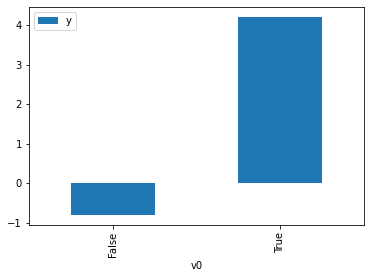

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

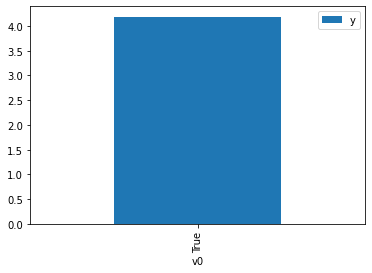

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.381384,False,0.148515,0.696738,1.435260
1,-0.692914,False,-0.996492,0.823302,1.214622
2,-0.341224,False,-1.413034,0.677141,1.476797
3,0.995339,False,2.480074,0.091715,10.903348
4,-1.819528,False,-2.025802,0.983632,1.016641
...,...,...,...,...,...
995,-0.052375,False,0.549894,0.521256,1.918442
996,0.780770,False,1.725949,0.141138,7.085283
997,0.407065,False,-0.061821,0.277340,3.605681
998,-1.502605,False,-2.075964,0.966965,1.034164


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.806837,True,3.152226,0.142162,7.034205
1,-1.054148,True,3.086059,0.086372,11.577759
2,-0.175199,True,4.510599,0.410029,2.438850
3,0.507889,True,5.912638,0.766120,1.305279
4,-0.186526,True,4.984382,0.403825,2.476321
...,...,...,...,...,...
995,0.376323,True,6.461822,0.708461,1.411511
996,-1.284725,True,2.714874,0.053046,18.851425
997,1.240032,True,6.965658,0.945228,1.057946
998,-1.894933,True,2.071187,0.013829,72.310707


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.939
Method:                 Least Squares   F-statistic:                              7752.
Date:                Wed, 20 Jul 2022   Prob (F-statistic):                        0.00
Time:                        18:54:54   Log-Likelihood:                         -1403.8
No. Observations:                1000   AIC:                                      2812.
Df Residuals:                     998   BIC:                                      2821.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7177      0.030     57.489      0.000       1.659       1.776
x2             4.9362      0.052     94.898      0.000       4.834       5.038
==============================================================================
Omnibus:                        3.505   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.173   Jarque-Bera (JB):                3.296
Skew:                          -0.090   Prob(JB):                        0.192
Kurtosis:                       2.785   Cond. No.                         1.83
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""